2022暑期学校，机器视觉大作业：猫狗分类。

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import time
import matplotlib.pyplot as plt


from model import Swin_Transformer
from model import swin_T
from model import ResNeXt
from model import ResNet



d:\learn\Computer\Machine Vision\code\Image_classification\model\ResNeXt.py:80: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(self.classifier.weight)
d:\learn\Computer\Machine Vision\code\Image_classification\model\ResNeXt.py:85: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(self.state_dict()[key], mode='fan_out')


In [2]:
# net = Swin_Transformer.SwinTransformer(
#     hidden_dim=96,
#     layers=(2, 2, 6, 2),
#     heads=(3, 6, 12, 24),
#     channels=3,
#     num_classes=3,
#     head_dim=32,
#     window_size=7,
#     downscaling_factors=(4, 2, 2, 2),
#     relative_pos_embedding=True
# )
input = torch.randn((10, 3, 224, 224))
net = swin_T.Swin_Model(
    dim=96,
    patch_size=4,
    num_heads=2,
    input_res=[56, 56],
    window_size=7,
    qkv_bias=True
)
resnet = ResNet.resnet18
resnext=ResNeXt.resnext
print(net)
out = net(input)
print(out)

Swin_Model(
  (patch_embed): Patch_Embeding(
    (patch): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (W_MSA_block): Swin_Block(
    (atten_norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    (atten): window_attention(
      (qkv): Linear(in_features=96, out_features=288, bias=True)
      (proj): Linear(in_features=96, out_features=96, bias=True)
    )
    (mlp_norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    (mlp): MLP(
      (fc1): Linear(in_features=96, out_features=384, bias=True)
      (actlayer): GELU()
      (fc2): Linear(in_features=384, out_features=96, bias=True)
    )
  )
  (SW_MSA_block): Swin_Block(
    (atten_norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    (atten): window_attention(
      (qkv): Linear(in_features=96, out_features=288, bias=True)
      (proj): Linear(in_features=96, out_features=96, bias=True)
    )
    (mlp_norm): LayerNorm((96,), eps=1e

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([2, 3, 224, 224])


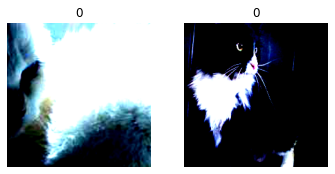

In [3]:
BATCH_SIZE=2
EPOCH=50
lr=0.0001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

valid_transform=transforms.Compose([
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
test_transform=transforms.Compose([
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
train_dataset =torchvision.datasets.ImageFolder(root='./dataset/train/',transform=train_transform)
train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE, shuffle=True,num_workers=0)

val_dataset = torchvision.datasets.ImageFolder(root='./dataset/val/',transform=valid_transform)
val_loader = DataLoader(val_dataset,batch_size=BATCH_SIZE,shuffle=True, num_workers=0)

test_dataset = torchvision.datasets.ImageFolder(root='./dataset/test/',transform=test_transform)
test_loader = DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=True, num_workers=0)

images, labels = next(iter(train_loader))
print(images.size())  # torch.Size([9, 1, 28, 28])
#plt.figure(figsize=(9, 9))
plt.figure(figsize=(9,9))
for i in range(2):
    plt.subplot(3, 3, i+1)
    plt.title(labels[i].item())
    plt.imshow(images[i].permute(1, 2, 0), cmap='gray')
    plt.axis('off')
plt.show()



In [4]:
def evaluate_accuracy(data_iter, net,epoch, device=None):
    if device is None and isinstance(net, torch.nn.Module):
        # 如果没指定device就使用net的device
        device = list(net.parameters())[0].device
    acc_sum, n = 0.0, 0
    with torch.no_grad():
        for X, y in data_iter:
            net.eval() # 评估模式, 这会关闭dropout
            acc_sum += (net(X.to(device)).argmax(dim=1) == y.to(device)).float().sum().cpu().item()
            net.train() # 改回训练模式
            n += y.shape[0]
    if acc_sum / n > 0.9:
        torch.save(net,'./trained_model/epoch %d acc %.3f.pth'% ((epoch+1),(acc_sum / n)))
    return acc_sum / n 

def train(net, train_iter, test_iter, batch_size, optimizer, device, num_epochs):
    net = net.cuda()
    print("training on ", device)
    Loss_list = []
    Accuracy_train_list = []
    Accuracy_test_list = []

    loss = torch.nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, batch_count, start = 0.0, 0.0, 0, 0, time.time()
        for X, y in train_iter:
            X = X.cuda()
            y = y.cuda()
            y_hat = net(X)
            print(y.shape)
            print(y_hat.shape)
            l = loss(y_hat, y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum += l.cpu().item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().cpu().item()
            n += y.shape[0]
            batch_count += 1
        test_acc = evaluate_accuracy(test_iter, net,epoch)
        Loss_list.append(train_l_sum / batch_count)
        Accuracy_train_list.append(100 *(train_acc_sum / n))
        Accuracy_test_list.append(100*test_acc)

        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, time %.1f sec'
              % (epoch + 1, train_l_sum / batch_count, train_acc_sum / n, test_acc, time.time() - start))
    
    x1 = range(0,EPOCH)
    
    plt.subplot(1,3,1)
    plt.plot(x1,Loss_list)
    plt.legend(['train_loss'])
    plt.subplot(1,3,2)
    plt.plot(x1,Accuracy_train_list)
    plt.legend(['train_acc'])
    plt.subplot(1,3,3)
    plt.plot(x1,Accuracy_test_list)
    plt.legend(['test_acc'])
    #plt.legend(['train_loss','train_acc','test_loss'])
    
    plt.show()


In [5]:
optimizer = torch.optim.Adam(ResNet.resnet18.parameters(), lr=lr)

train(ResNet.resnet18,train_loader,test_loader,BATCH_SIZE,optimizer,device,EPOCH)

training on  cuda
torch.Size([2])
torch.Size([2, 2])
torch.Size([2])
torch.Size([2, 2])
torch.Size([2])
torch.Size([2, 2])
torch.Size([2])
torch.Size([2, 2])
torch.Size([2])
torch.Size([2, 2])
torch.Size([2])
torch.Size([2, 2])
torch.Size([2])
torch.Size([2, 2])
torch.Size([2])
torch.Size([2, 2])
torch.Size([2])
torch.Size([2, 2])
torch.Size([2])
torch.Size([2, 2])
torch.Size([2])
torch.Size([2, 2])
torch.Size([2])
torch.Size([2, 2])
torch.Size([2])
torch.Size([2, 2])
torch.Size([2])
torch.Size([2, 2])
torch.Size([2])
torch.Size([2, 2])
torch.Size([2])
torch.Size([2, 2])
torch.Size([2])
torch.Size([2, 2])
torch.Size([2])
torch.Size([2, 2])
torch.Size([2])
torch.Size([2, 2])
torch.Size([2])
torch.Size([2, 2])
torch.Size([2])
torch.Size([2, 2])
torch.Size([2])
torch.Size([2, 2])
torch.Size([2])
torch.Size([2, 2])
torch.Size([2])
torch.Size([2, 2])
torch.Size([2])
torch.Size([2, 2])
torch.Size([2])
torch.Size([2, 2])
torch.Size([2])
torch.Size([2, 2])
torch.Size([2])
torch.Size([2, 2])
to

KeyboardInterrupt: 

In [15]:
torch.cuda.empty_cache()

In [16]:
optimizer = torch.optim.Adam(resnext.parameters(), lr=lr)

train(resnext,train_loader,test_loader,BATCH_SIZE,optimizer,device,EPOCH)

training on  cuda


RuntimeError: CUDA out of memory. Tried to allocate 26.00 MiB (GPU 0; 6.00 GiB total capacity; 5.33 GiB already allocated; 0 bytes free; 5.35 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [7]:
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
train(net,train_loader,val_loader,BATCH_SIZE,optimizer,device,EPOCH)

training on  cuda


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [5]:
from torchvision import transforms
from torch.autograd import Variable
from PIL import Image

transform = transforms.Compose([
            #transforms.Scale(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

idx_to_class = {0:'cat', 1:'dog'}

inference_model=torch.load('./trained_model/ResNet18.pth')
#inference_model=torch.load('./trained_model/Swin_T.pth')

def predict(use_cuda, model, image_name):
    test_image = Image.open(image_name)
    test_image_tensor = transform(test_image)
    if use_cuda:
        model.cuda()
        test_image_tensor = test_image_tensor.cuda()
        print('all on cuda')
    else:
        test_image_tensor = test_image_tensor
    test_image_tensor = Variable(torch.unsqueeze(test_image_tensor, dim=0).float(), requires_grad=False)

    with torch.no_grad():
        model.eval()
        #print(model)
        out = model(test_image_tensor)
        ps = torch.exp(out)  #Softmax操作，转换成概率分布
        ps = ps / torch.sum(ps)
        topk, topclass = ps.topk(1, dim=1)
        return(idx_to_class[topclass.cpu().numpy()[0][0]], topk.cpu().numpy()[0][0])

image_path = './dataset/test/dog/dog.7.jpg'
predict(1,inference_model,image_path)


all on cuda


('dog', 0.99748594)